Loaded original PCA data
Dataset shape: (2726, 21)
Automatically detected elbow point: 3 clusters


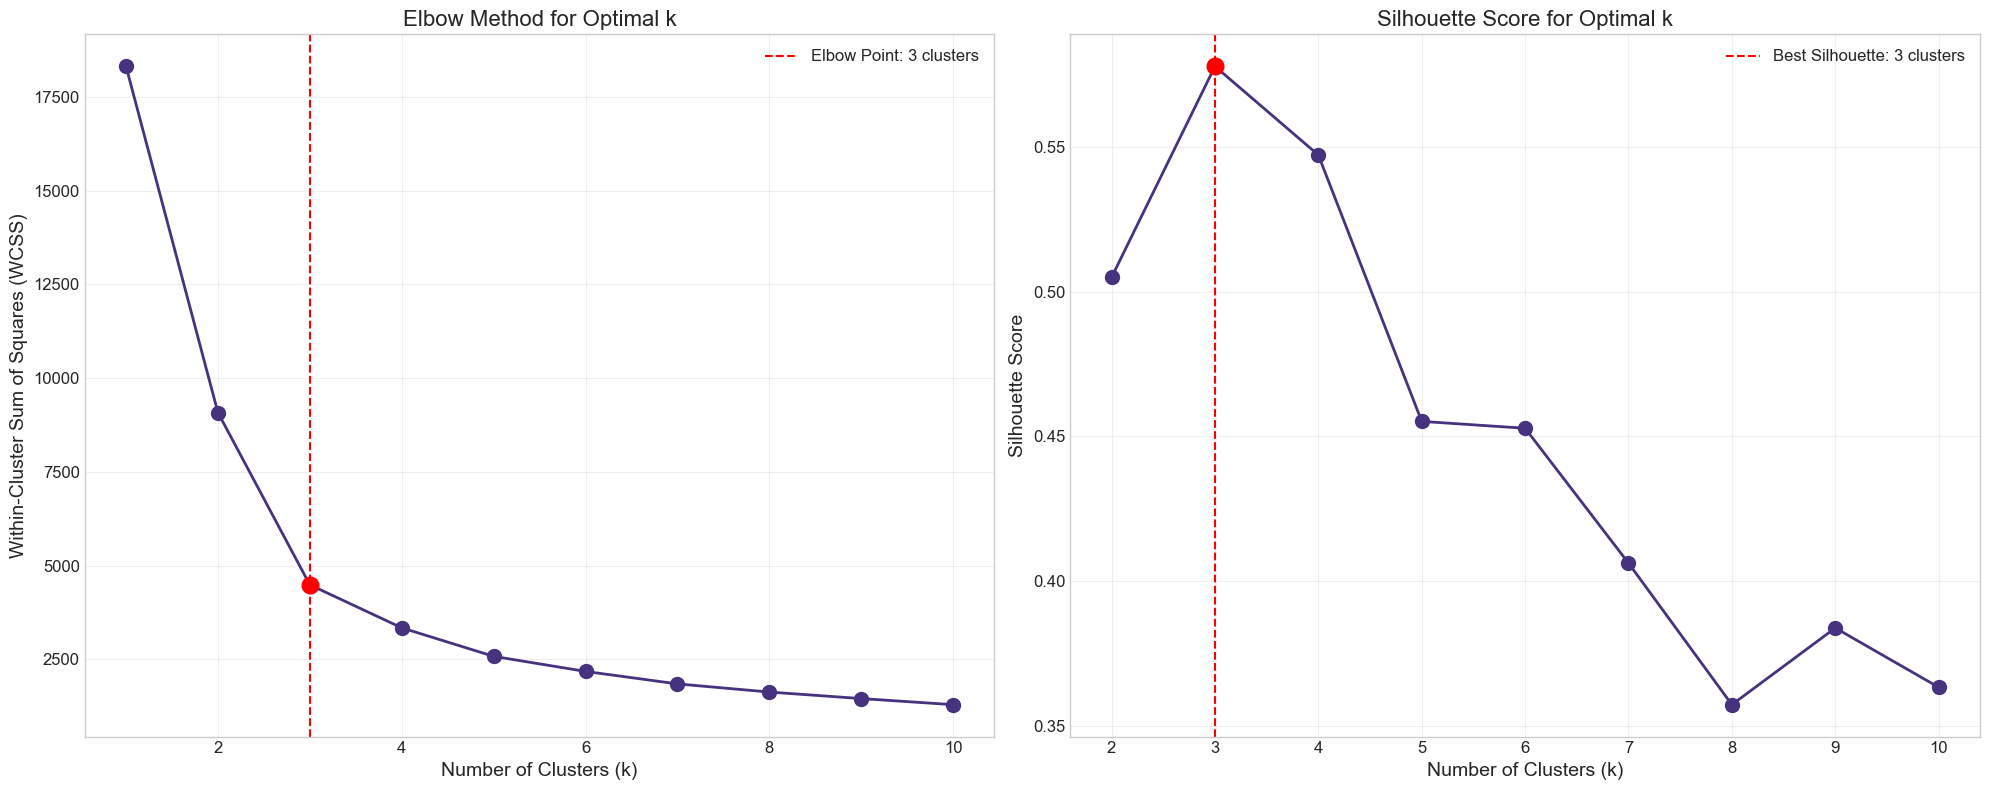

Examining cluster solutions for k values: [2, 3, 4]


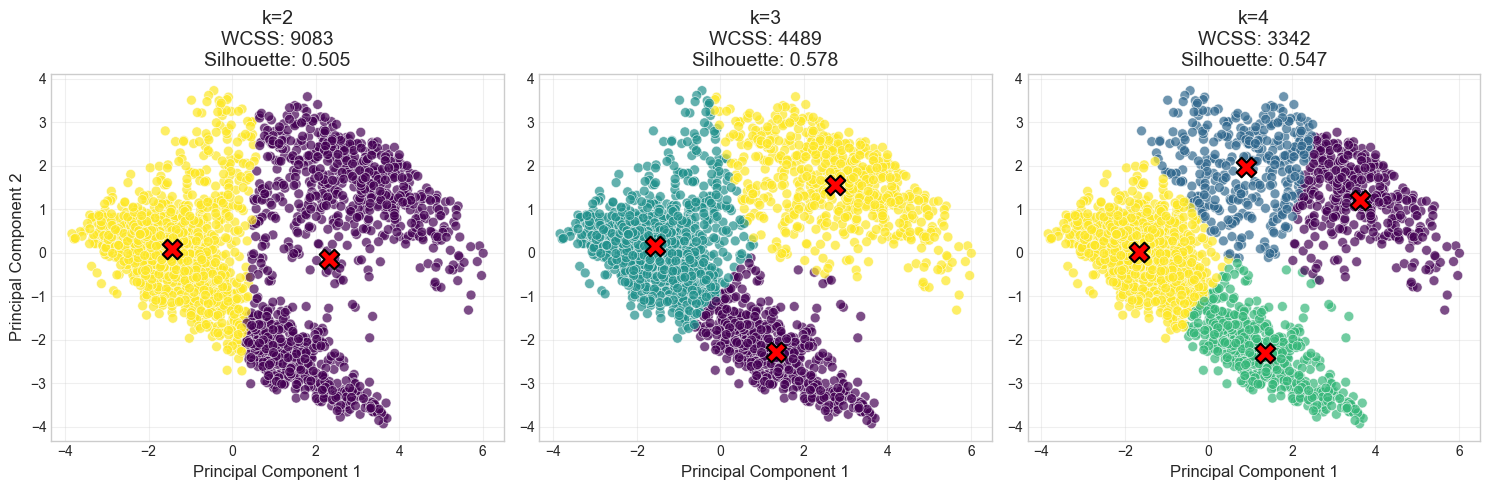


=== CLUSTERING RECOMMENDATION ===
Elbow Method suggests 3 clusters.
Silhouette Score analysis suggests 3 clusters.

Final recommendation: 3 clusters
Note: Please review the visual results to confirm this matches your understanding of the data structure.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator  # For automatic elbow detection
import seaborn as sns

# Load the most recent PCA data
try:
    pca_data = pd.read_csv('final.csv')
    print("Loaded enhanced PCA data with filled regions")
except FileNotFoundError:
    try:
        pca_data = pd.read_csv('pca_with_all_regions_filled.csv')
        print("Loaded PCA data with filled regions")
    except FileNotFoundError:
        try:
            pca_data = pd.read_csv('pca_cleaned_absolutely_final.csv')
            print("Loaded cleaned PCA data")
        except FileNotFoundError:
            pca_data = pd.read_csv('pca.csv')
            print("Loaded original PCA data")

print(f"Dataset shape: {pca_data.shape}")

# Extract the PCA components for clustering
X = pca_data[['PC1', 'PC2']].values

# 1. ELBOW METHOD
# Calculate WCSS (Within-Cluster Sum of Square) for different numbers of clusters
wcss = []
silhouette_scores = []
range_n_clusters = range(1, 11)  # Try 1 to 10 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score (not valid for single cluster)
    if n_clusters > 1:
        cluster_labels = kmeans.predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)  # Placeholder for n_clusters=1

# Try to automatically identify the elbow point
try:
    from kneed import KneeLocator
    kl = KneeLocator(range_n_clusters, wcss, curve='convex', direction='decreasing')
    elbow_point = kl.elbow
    print(f"Automatically detected elbow point: {elbow_point} clusters")
except:
    print("Could not automatically detect elbow point. Please interpret the plot manually.")
    elbow_point = None

# 2. CREATE VISUALIZATIONS
# Set up a nicer plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the elbow method
ax1.plot(range_n_clusters, wcss, marker='o', linestyle='-', linewidth=2, markersize=10)
if elbow_point:
    ax1.axvline(x=elbow_point, color='r', linestyle='--', 
                label=f'Elbow Point: {elbow_point} clusters')
    ax1.plot(elbow_point, wcss[elbow_point-1], 'ro', markersize=12)

ax1.set_title('Elbow Method for Optimal k', fontsize=16)
ax1.set_xlabel('Number of Clusters (k)', fontsize=14)
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot the silhouette scores
ax2.plot(range_n_clusters[1:], silhouette_scores[1:], marker='o', linestyle='-', 
         linewidth=2, markersize=10)
best_silhouette = np.argmax(silhouette_scores[1:]) + 2  # +2 because we start from 2 clusters and index from 0
ax2.axvline(x=best_silhouette, color='r', linestyle='--', 
            label=f'Best Silhouette: {best_silhouette} clusters')
ax2.plot(best_silhouette, silhouette_scores[best_silhouette-1], 'ro', markersize=12)

ax2.set_title('Silhouette Score for Optimal k', fontsize=16)
ax2.set_xlabel('Number of Clusters (k)', fontsize=14)
ax2.set_ylabel('Silhouette Score', fontsize=14)
ax2.set_xticks(range(2, 11))
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('elbow_and_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. DETAILED EXAMINATION OF DIFFERENT K VALUES
# Find the optimal k values suggested by both methods
optimal_k_values = set()
if elbow_point:
    optimal_k_values.add(elbow_point)
optimal_k_values.add(best_silhouette)

# Add a few neighboring values for comparison
for k in list(optimal_k_values):
    if k-1 > 1:
        optimal_k_values.add(k-1)
    optimal_k_values.add(k+1)

optimal_k_values = sorted(list(optimal_k_values))
print(f"Examining cluster solutions for k values: {optimal_k_values}")

# Create a multi-panel plot to visualize these different clustering solutions
fig, axes = plt.subplots(1, len(optimal_k_values), figsize=(5*len(optimal_k_values), 5))
if len(optimal_k_values) == 1:
    axes = [axes]  # Make sure axes is a list for single plot

for i, k in enumerate(optimal_k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    
    # Calculate metrics
    wcss_value = kmeans.inertia_
    silhouette_avg = silhouette_score(X, cluster_labels) if k > 1 else 0
    
    # Plot
    scatter = axes[i].scatter(X[:, 0], X[:, 1], c=cluster_labels, 
                              cmap='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.5)
    axes[i].scatter(centroids[:, 0], centroids[:, 1], 
                    marker='X', s=200, c='red', edgecolor='black', linewidth=1.5)
    
    axes[i].set_title(f'k={k}\nWCSS: {wcss_value:.0f}\nSilhouette: {silhouette_avg:.3f}', fontsize=14)
    axes[i].set_xlabel('Principal Component 1', fontsize=12)
    if i == 0:
        axes[i].set_ylabel('Principal Component 2', fontsize=12)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_solutions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. FINAL RECOMMENDATION
print("\n=== CLUSTERING RECOMMENDATION ===")
if elbow_point:
    print(f"Elbow Method suggests {elbow_point} clusters.")
print(f"Silhouette Score analysis suggests {best_silhouette} clusters.")

# Final recommended k
final_recommendation = best_silhouette
if elbow_point and abs(elbow_point - best_silhouette) <= 1:
    # If both methods agree or are close, use the elbow method result
    final_recommendation = elbow_point

print(f"\nFinal recommendation: {final_recommendation} clusters")
print("Note: Please review the visual results to confirm this matches your understanding of the data structure.")